In [1]:
%load_ext autoreload
%autoreload 2


In [4]:
import numpy as np
import pandas as pd
import nibabel as nib
from tree_features import connectome_average, matrix_fusion, tree_connectivity
from tree_features import tree_dictionary, get_module_img, cross_modularity, add_gamma_to_lvl_dict
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)


### Generate population-tree features for each given tree span and gamma parameter

In [3]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [4]:
fcm, scm = connectome_average(fc_group, sc_group)

In [7]:
lvlmin = 2
lvlmax = 30
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
thrs_tree = {}
for g in np.arange(0, 1.1, 0.1):
    crossmod = []
    for l in range(lvlmin,lvlmax):
        c, thrs = cross_modularity(fcm, scm, g, l)
        thrs_tree.update(add_gamma_to_lvl_dict(thrs, g))
        crossmod.append(c)
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))


/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:97: RuntimeWarning: invalid value encountered in double_scalars
  crossmod = pow((np.array(sims).mean() * mod_sc * mod_fc), (1 / 3))


In [41]:
g = 1
lvlmin = 2
lvlmax = 30

W = matrix_fusion(g, fcm, scm)
T = tree_modules(W,12)
lvel = level_dictionary(T)
sim, _ = threshold_based_similarity(fcm, scm, lvel)
np.array(sim).mean()

0.5871917636229729

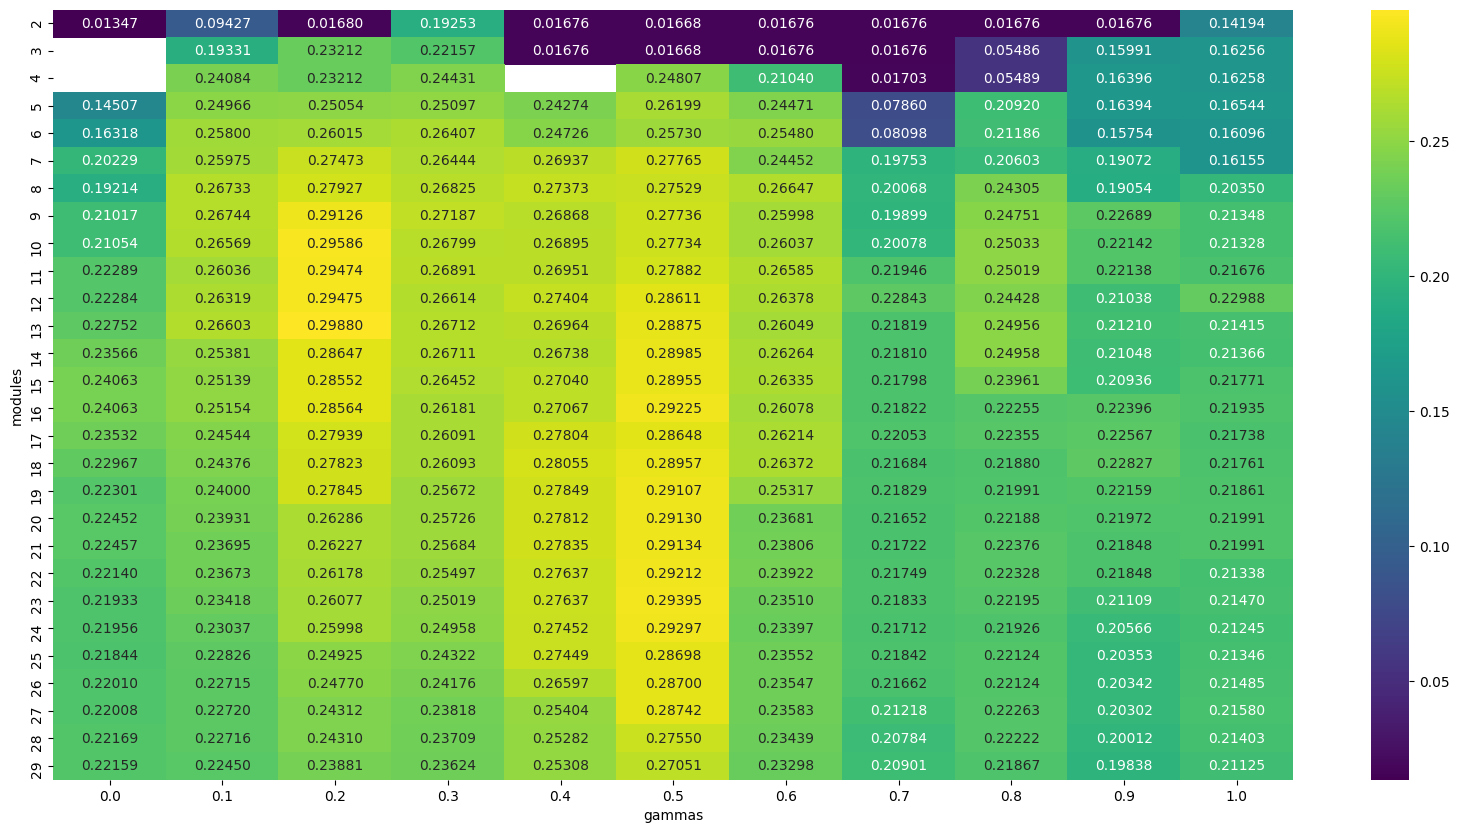

In [8]:
import seaborn as sns
s = sns.heatmap(crossmod_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".5f")
_ = s.set(xlabel='gammas', ylabel='modules')

<AxesSubplot:>

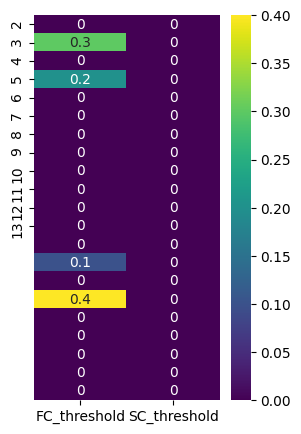

In [53]:
x,y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
key_pattern = "gamma_" + str(gammas_vec[y-1][0]) + "_lvl_" + str(levels_vec[x][0]) + "_mod_"
thresholds = [value for key,value in thrs_tree.items() if key.startswith(key_pattern)]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(thresholds, cmap='viridis', annot=True, ax = ax,
    yticklabels=np.arange(lvlmin, levels_vec[x]+1),
    xticklabels = np.array(['FC_threshold', 'SC_threshold']))


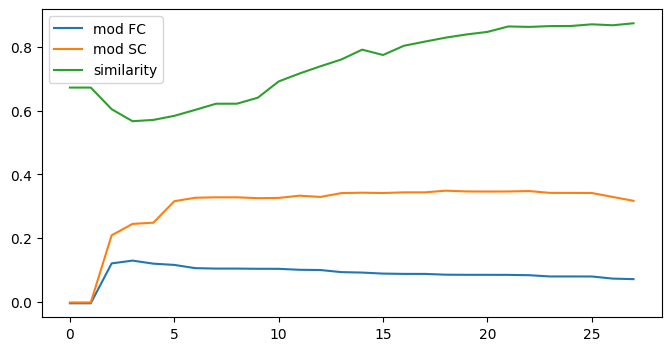

In [51]:
from tree_features import modularity, threshold_based_similarity, tree_modules, matrix_fusion, level_dictionary

g = 0.5
lvlmin = 2
lvlmax = 30

W = matrix_fusion(g, fcm, scm)

mod_fc = []
mod_sc = []
similarity = []
for l in range(lvlmin,lvlmax):
    T = tree_modules(W, l)
    lvel = level_dictionary(T)
    mod_fc.append(modularity(fcm, T))
    mod_sc.append(modularity(scm, T))
    sim, _ = threshold_based_similarity(fcm, scm, lvel)
    similarity.append(np.array(sim).mean())

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(mod_fc, label='mod FC')
ax.plot(mod_sc, label='mod SC')
ax.plot(similarity, label='similarity')
ax.legend()

In [119]:
from tree_features import level_dictionary, tree_modules, matrix_fusion
W = matrix_fusion(1, fcm, scm)
T = tree_modules(W, 12)
lvel = level_dictionary(T)
#filteredroi = scm[:,lvel["lvl_2_mod_2"]]
#filteredroi.sum()
for i,l in enumerate(lvel):
    print("Module " + str(i+1) + " number of rois " + str(len(lvel[l])))

Module 1 number of rois 65
Module 2 number of rois 432
Module 3 number of rois 60
Module 4 number of rois 1
Module 5 number of rois 1
Module 6 number of rois 3
Module 7 number of rois 33
Module 8 number of rois 366
Module 9 number of rois 261
Module 10 number of rois 424
Module 11 number of rois 410
Module 12 number of rois 72


In [ ]:
from nilearn import plotting

atlas_name = "craddock_2128_2mm.nii.gz"
atlas = nib.load(os.path.join(project_path, atlas_name))
g = 1
l = 12
W = matrix_fusion(g, fcm, scm)
T = tree_modules(W, l)
lvel = level_dictionary(T)
#filteredroi = scm[:,lvel["lvl_2_mod_2"]]
#filteredroi.sum()
for l in lvel:
    rois = lvel[l]
    mod_img = get_module_img(atlas, rois)
    plotting.plot_glass_brain(mod_img, title=l)

In [6]:
for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm, scm)
    tree_min = 17
    tree_max = 22
    t_dict = tree_dictionary(tree_min, tree_max, W)
    json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "w"))
    full_features = []
    for sc, fc in zip(sc_group, fc_group):
        t_features, t_features_names = tree_connectivity(t_dict, sc, fc)
        full_features.append(t_features)

    full_df = pd.DataFrame(full_features)
    full_df.columns = t_features_names
    full_df.to_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"), index=False)


## Extract features from lifespan data

In [3]:
from tree_features import tree_connectivity_fc
connectomes_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
trees_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon/df_connectomes"

#sc_lifespan_group = load_data(os.path.join(project_path, "sc"))
fc_lifespan_group = load_data(os.path.join(connectomes_path, "fc"))


In [5]:
import glob

files = sorted(glob.glob(connectomes_path + "/fc/*.csv"))
name = [(os.path.basename(x)).split('.')[0] for x in files]
len(fc_lifespan_group)

147

In [7]:

#for g in np.arange(0, 1.1, 0.1):
g=1.0
tree = json.loads(open(os.path.join(trees_path, 
    "tree_features_g_" + str(round(g, 2)) + ".json")).read())
full_features = []
for fc in fc_lifespan_group:
    t_features, t_features_names = tree_connectivity_fc(tree, fc)
    full_features.append(t_features)

full_df = pd.DataFrame(full_features)
full_df.columns = t_features_names
full_df.to_csv(os.path.join(connectomes_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"), index=False)


/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:134: RuntimeWarning: Mean of empty slice
  fc_int = np.nanmean(fc[int_rois, :][:, int_rois], dtype=float)
/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:135: RuntimeWarning: Mean of empty slice
  fc_out = np.nanmean(fc[int_rois[:, None], ext_rois], dtype=float)


### Store a nifti of a given module

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import json

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.5.json"), "r").read())
rois = t_dictionary['lvl_20_mod_3']

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
atlas_data = atlas.get_fdata()
atlas_rois = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
atlas_rois_image = nib.Nifti1Image(atlas_rois, affine=atlas.affine)
nib.save(atlas_rois_image, os.path.join(project_path, "craddock_2128_2mm_lvl_20_mod_3.nii.gz"))


### Neuropsychological score prediction using population-tree features

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nilearn import plotting
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, GridSearchCV
from scipy import stats
from reg_functions import get_mae_cv, univariate_feature_ranking, iterative_regression, optimal_brain_map
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import kruskal, pearsonr
import seaborn as sns

## CVLT test (verbal memory)

(array([ 1.,  0.,  2.,  3., 13., 15., 21., 22., 33., 26.]),
 array([-7.5229775 , -6.47451775, -5.42605799, -4.37759824, -3.32913848,
        -2.28067873, -1.23221897, -0.18375922,  0.86470054,  1.91316029,
         2.96162005]),
 <BarContainer object of 10 artists>)

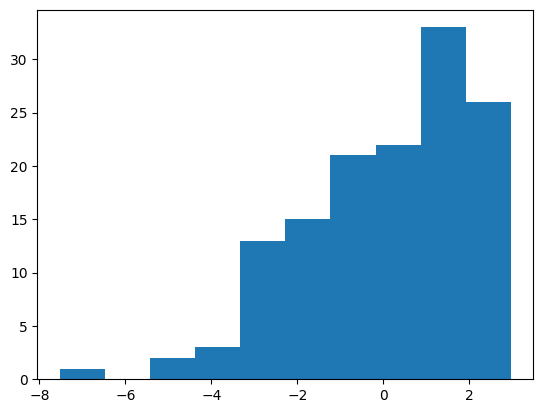

In [2]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
plt.hist(y)

#### Only training (cross-validation) using five different linear models

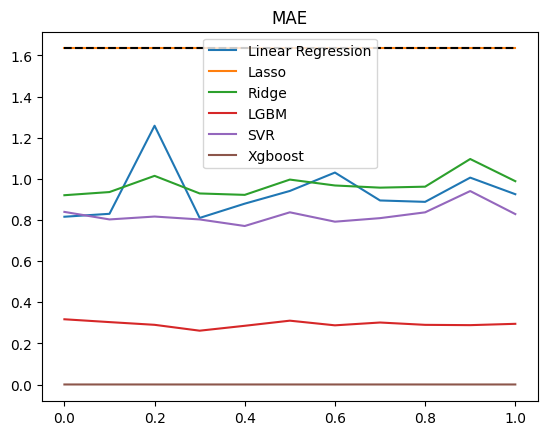

In [3]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
clf_6 = XGBRegressor()

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        mae, mae_std = get_mae_cv(X, y, clf,5)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()
mae_mean = np.mean(np.abs(y-np.mean(y)))

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

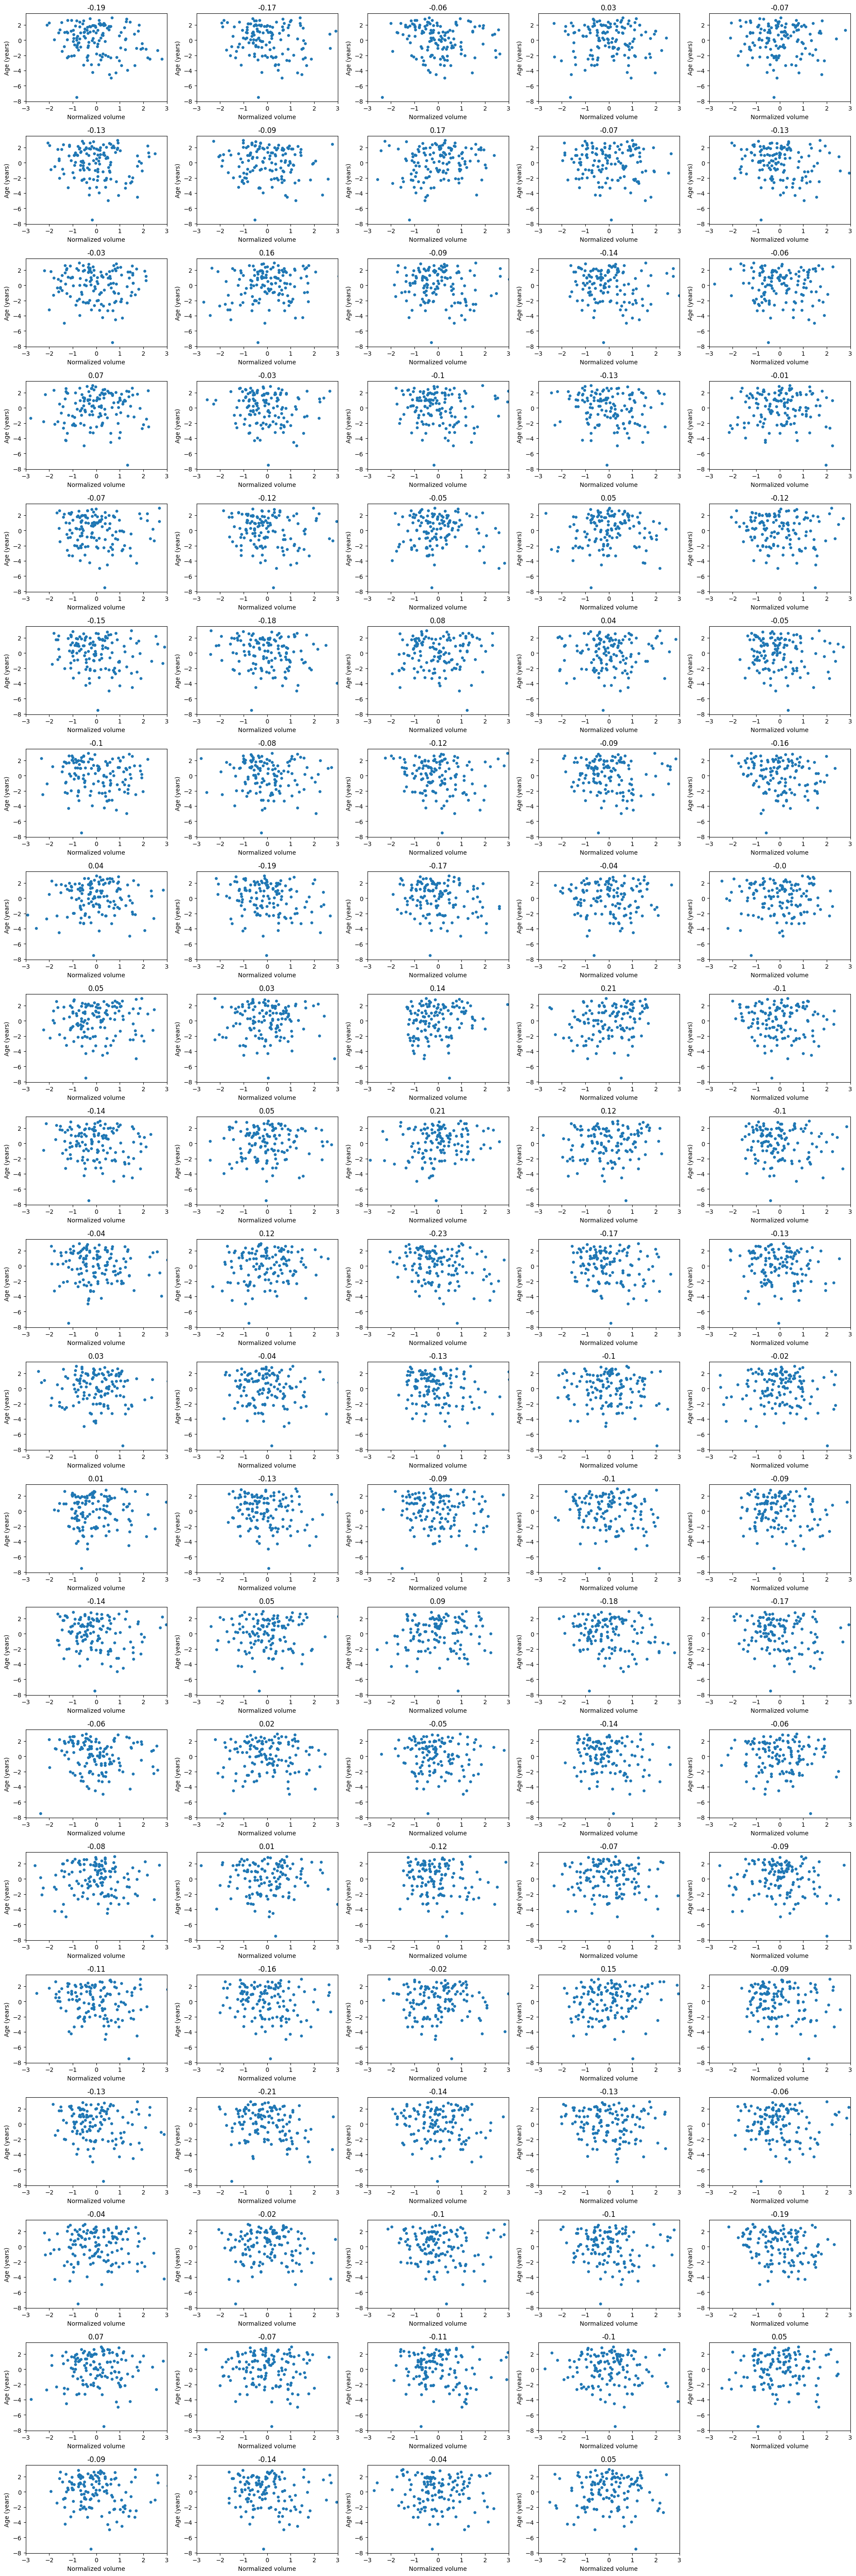

In [26]:
g=0.3
scaler = StandardScaler()

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
features = scaler.fit_transform(df)
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
# Explore relationship between each individual feature and age.
plt.figure(figsize=(20, 60))
valid_feat = []
for d in range (features.shape[1]):
    plt.subplot(21,5,d+1)
    plt.scatter(features[:,d],y,s=15)
    pearson_coeff, _ = pearsonr(features[:, d], y)
    if np.abs(pearson_coeff) > 0.15:
        valid_feat.append(d)
    plt.xlabel('Normalized volume')
    plt.ylabel('Age (years)')
    plt.xlim([-3.0, 3.0])
    plt.title(str(round(pearson_coeff, 2)))
plt.tight_layout()
plt.show()

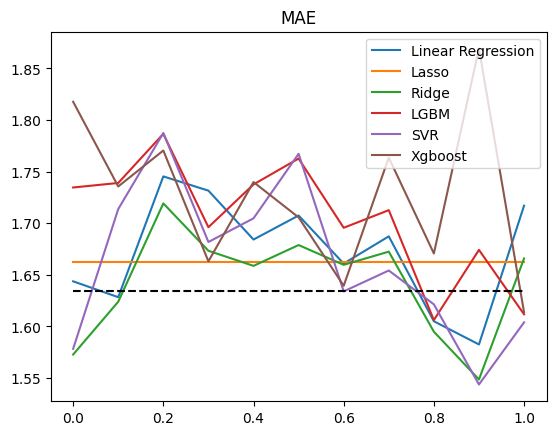

In [3]:
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        valid_feat = []
        r_values = []
        for d in range (X.shape[1]):
            pearson_coeff, _ = pearsonr(X[:, d], y)
            if np.abs(pearson_coeff) > 0.15:
                valid_feat.append(d)
                r_values.append(pearson_coeff)
        good_features = X[:, valid_feat]
        mae, mae_std = get_mae_cv(good_features, y, clf, 5)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

### Using SVR and rank

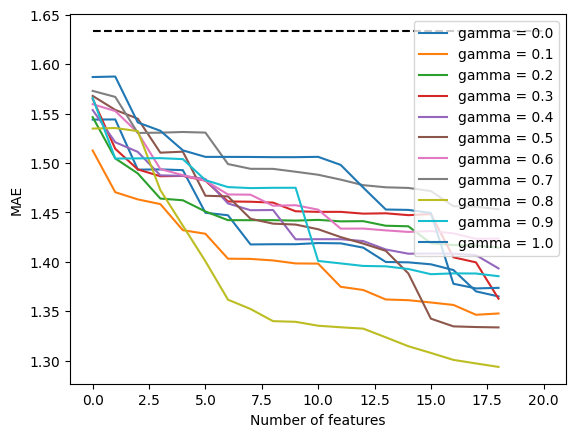

In [4]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"

y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, clf_5, folds=5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

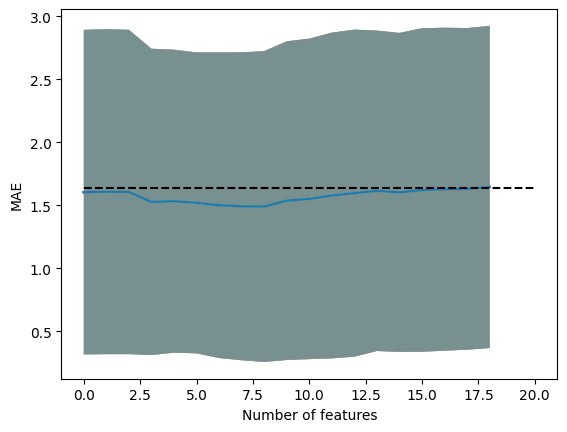

In [6]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"

y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    g = 0.8
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, clf_5, folds=5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

array([[1.        , 0.78673655],
       [0.78673655, 1.        ]])

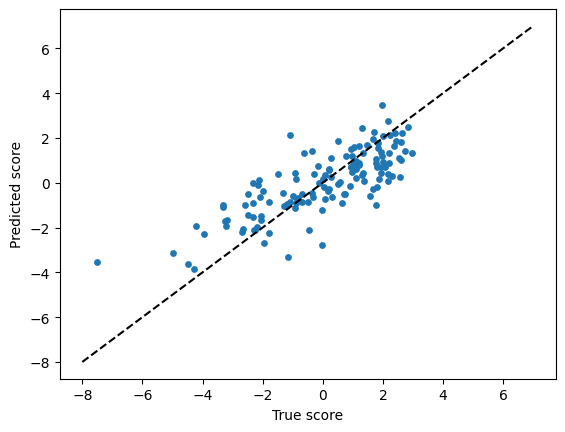

In [11]:
g = 0.8
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
#Y_pred = cross_val_predict(clf_3, Xsorted[:,:15], y, cv=5)
reg = clf_3.fit(Xsorted, y)
Y_pred = reg.predict(Xsorted)
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.plot(range(-8, 8), range(-8,8), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

In [13]:
atlas_name = "craddock_2128_2mm.nii.gz"
brainmap = optimal_brain_map(project_path, atlas_name, names_sorted[:5], r_vals_sorted[:5], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')


KeyError: 'lvl_11_mod_2'

## Aging prediction using population-tree features

(147, 2980)

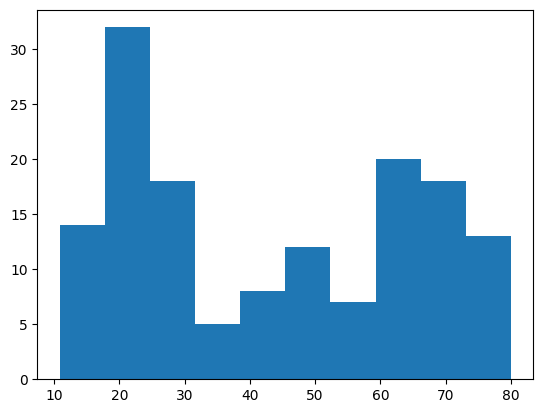

In [10]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
y_df = pd.read_csv(os.path.join(project_path, "ages.csv"))


y = y_df["age"].values
labels = y_df["subject"].values

plt.hist(y)

df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(0.5, 2)) + ".csv"))
df_nonans = df.dropna(axis=1, how='any')

df_nonans.shape



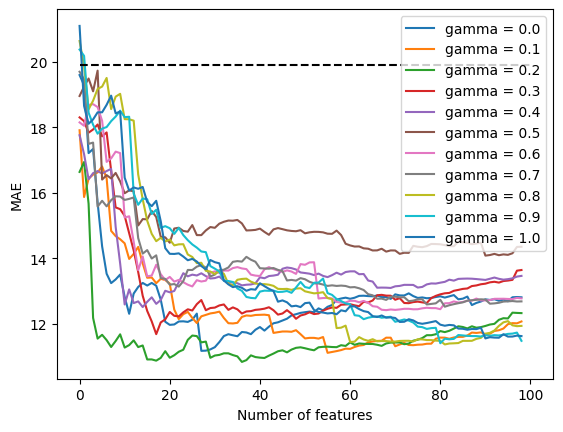

In [58]:

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
clf_6 = XGBRegressor()

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
scaler = StandardScaler()
iterations = 100
for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
    df_nonans = df.dropna(axis=1, how='any')
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df_nonans, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, iterations, clf_7, folds=5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, iterations], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")


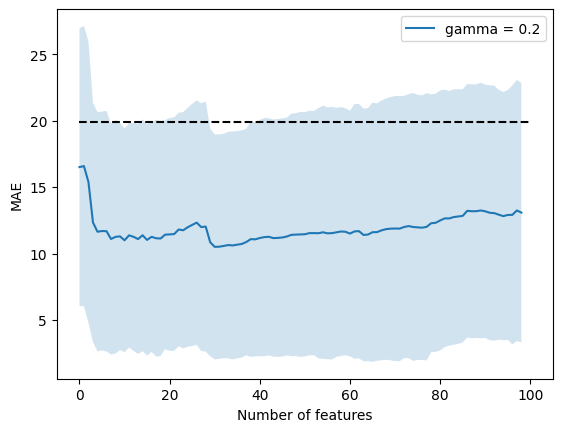

In [25]:

g = 0.2
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
df_filtered = df.dropna(axis=1, how='any')

Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df_filtered, y)
mae_mean, mae_std = iterative_regression(Xsorted, y, iterations, clf_5, folds=5)

plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
plt.fill_between(np.arange(0, iterations-1), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
plt.xlabel("Number of features")
plt.ylabel("MAE")
plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, iterations], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")
features_for_minmae = np.array(mae_mean).argmin()


array([[1.        , 0.73863897],
       [0.73863897, 1.        ]])

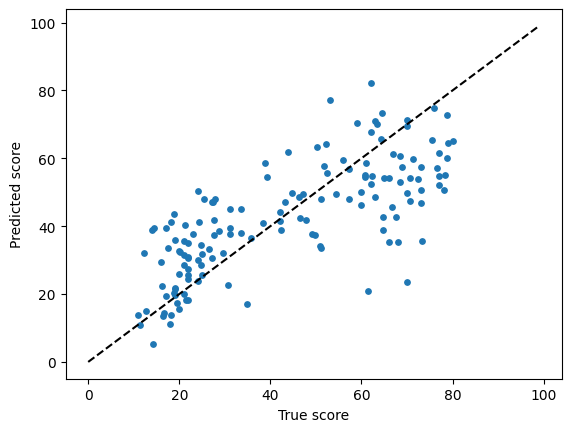

In [19]:
g = 0.2
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
df_filtered = df.dropna(axis=1, how='any')
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df_filtered, y)
Y_pred = cross_val_predict(clf_5, Xsorted[:,:5], y, cv=5)
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.plot(range(0, 100), range(0,100), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

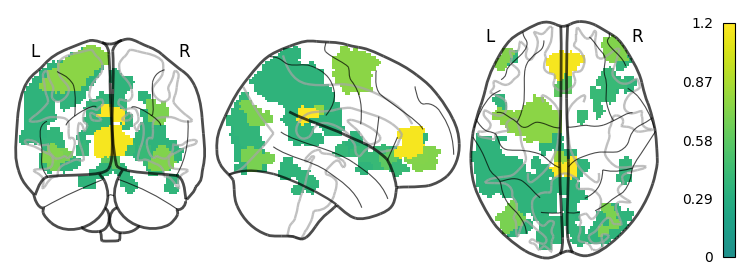

In [40]:
atlas_name = "craddock_2128_2mm.nii.gz"
tree_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
g = 0.2
label_dict = json.loads(open(os.path.join(tree_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
brainmap = optimal_brain_map(tree_path, atlas_name, 
    names_sorted[:features_for_minmae], r_vals_sorted[:features_for_minmae], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')


In [48]:

X_sorted_100features = Xsorted[:,:100]
X_sorted_100features_names = names_sorted[:100]

xsorted_df = pd.DataFrame(X_sorted_100features)
xsorted_df.columns = X_sorted_100features_names
xsorted_df.to_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(0.2) + "_best100corr.csv"), index=False)



In [56]:
X_sorted_100features = Xsorted[:,:10]
mae, maestd = get_mae_cv(X_sorted_100features, y, clf_4, 5)
mae

18.90171301538217